In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error

from xgboost import XGBRegressor

In [5]:
csv_path = Path("./Housing.csv")
df = pd.read_csv(csv_path)

target_col ='price'

y = df[target_col].values
X = df.drop(columns=[target_col])

numeric_features = X.select_dtypes(include="number").columns.tolist()
categorical_features = X.select_dtypes(exclude="number").columns.tolist()

print("Target:", target_col)
print("Numeric:", len(numeric_features), "| Categorical:", len(categorical_features))

Target: price
Numeric: 6 | Categorical: 6


In [6]:
# 1) train/test
X_tmp, X_test, y_tmp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
# 2) train/valid
X_train, X_valid, y_train, y_valid = train_test_split(
    X_tmp, y_tmp, test_size=0.2, random_state=42
)

# Препроцессинг: числовые -> median, категориальные -> most_frequent + OneHot
numeric_tf = Pipeline([("imputer", SimpleImputer(strategy="median"))])
categorical_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocess = ColumnTransformer([
    ("num", numeric_tf, numeric_features),
    ("cat", categorical_tf, categorical_features),
])

# Fit только на train, transform train/valid/test
preprocess.fit(X_train)
X_tr = preprocess.transform(X_train)
X_va = preprocess.transform(X_valid)
X_te = preprocess.transform(X_test)

# Соберём имена признаков после OHE
oh = preprocess.named_transformers_["cat"].named_steps["onehot"] if categorical_features else None
num_names = numeric_features
cat_names = oh.get_feature_names_out(categorical_features).tolist() if oh is not None else []
feature_names = num_names + cat_names

X_tr.shape, X_va.shape, X_te.shape, len(feature_names)


((348, 18), (88, 18), (110, 18), 18)

In [9]:
xgb = XGBRegressor(
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    tree_method="hist",
    random_state=42,
    n_jobs=-1,

    eval_metric="rmse",
    early_stopping_rounds=50
)

xgb.fit(
    X_tr, y_train,
    eval_set=[(X_va, y_valid)]
)



[0]	validation_0-rmse:26611.43207
[1]	validation_0-rmse:25850.42275
[2]	validation_0-rmse:25129.79314
[3]	validation_0-rmse:24443.68996
[4]	validation_0-rmse:23809.68001
[5]	validation_0-rmse:23088.47823
[6]	validation_0-rmse:22621.01103
[7]	validation_0-rmse:22095.24908
[8]	validation_0-rmse:21702.74878
[9]	validation_0-rmse:21146.75082
[10]	validation_0-rmse:20728.63765
[11]	validation_0-rmse:20338.91026
[12]	validation_0-rmse:19979.75664
[13]	validation_0-rmse:19625.38221
[14]	validation_0-rmse:19231.20762
[15]	validation_0-rmse:18885.37729
[16]	validation_0-rmse:18679.50052
[17]	validation_0-rmse:18370.59963
[18]	validation_0-rmse:18089.85359
[19]	validation_0-rmse:17836.05261
[20]	validation_0-rmse:17624.03498
[21]	validation_0-rmse:17357.46750
[22]	validation_0-rmse:17182.41801
[23]	validation_0-rmse:17000.26442
[24]	validation_0-rmse:16807.39930
[25]	validation_0-rmse:16662.79402
[26]	validation_0-rmse:16530.29128
[27]	validation_0-rmse:16376.27568
[28]	validation_0-rmse:16193.0

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,'rmse'


In [10]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred) ** 0.5  # совместимо с любой версией sklearn

y_pred = xgb.predict(X_te)
print(f"R^2 (test): {r2_score(y_test, y_pred):.4f}")
print(f"RMSE (test): {rmse(y_test, y_pred):,.2f}")

# лучшая итерация по ранней остановке
print("Best iteration:", xgb.best_iteration)


R^2 (test): 0.6880
RMSE (test): 14,436.58
Best iteration: 89


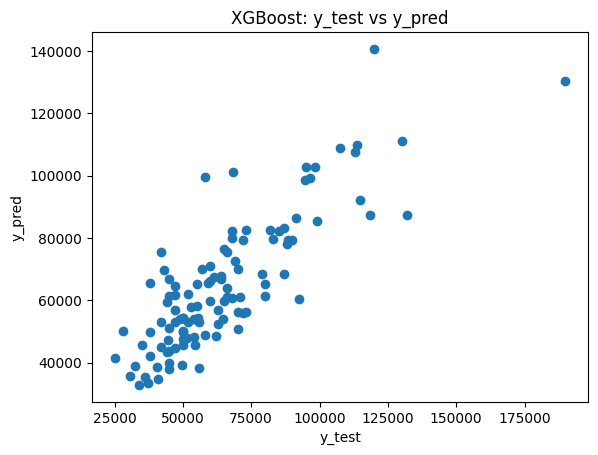

In [11]:
plt.figure()
plt.scatter(y_test, y_pred)
plt.title("XGBoost: y_test vs y_pred")
plt.xlabel("y_test"); plt.ylabel("y_pred")
plt.show()


In [12]:
importances = xgb.feature_importances_
imp_df = (pd.DataFrame({
    "feature": feature_names if len(feature_names)==len(importances) else [f"f{i}" for i in range(len(importances))],
    "importance": importances
})
.sort_values("importance", ascending=False)
.head(15))

imp_df


,feature,importance
3,bathrms,0.166335
1,lotsize,0.082985
14,airco_no,0.081090
15,airco_yes,0.080555
13,gashw_yes,0.067283
12,gashw_no,0.064688
10,fullbase_no,0.057244
5,garagepl,0.056749
7,driveway_yes,0.055831
16,prefarea_no,0.049928


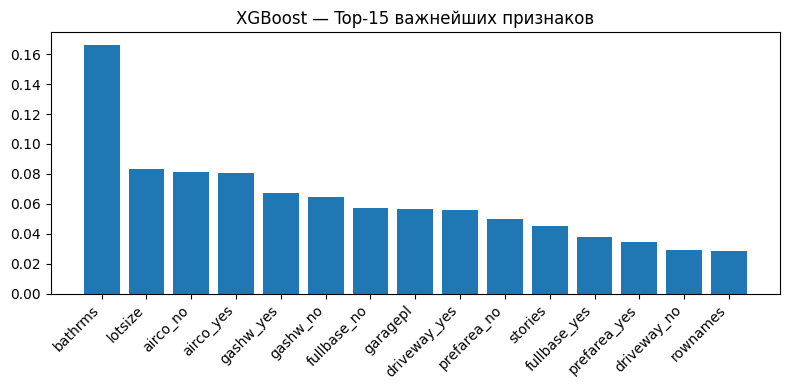

In [13]:
plt.figure(figsize=(8,4))
plt.bar(imp_df["feature"], imp_df["importance"])
plt.title("XGBoost — Top-15 важнейших признаков")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
